# 1. Подготовка

In [1]:
# загрузка модулей
# операции с массивом данных
import pandas as pd
# наивная модель
from sklearn.dummy import DummyClassifier
# логистическая модель
from sklearn.linear_model import LogisticRegression
# метрика f1
from sklearn.metrics import f1_score, confusion_matrix
# оценка важности слов
from sklearn.feature_extraction.text import TfidfVectorizer
# разбиение выборочной совокупности
from sklearn.model_selection import train_test_split
# перемешивание данных
from sklearn.utils import shuffle
# лемматизация
from pymystem3 import Mystem
# регуляторные выражения
import re
import nltk
# стоп-слова
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords
import warnings
warnings.filterwarnings("ignore")
# графическая иллюстрация
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

[nltk_data] Downloading package stopwords to /home/urma/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# загрузка массива данных
comments = pd.read_csv('toxic_comments.csv')

In [3]:
# вывод первых пяти наблюдений выборочной совокупности
comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
# вывод общей информации о выборочной совокупности
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


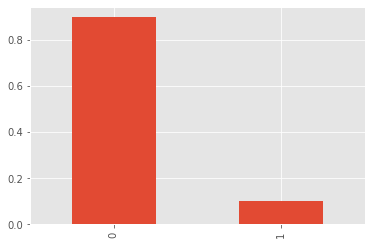

In [5]:
# вывод процентного соотношения различных величин целевого признака
comments['toxic'].value_counts(normalize=True).plot(kind='bar')

Имеем несбалансированность классов целевого признака:
- положительные комментарии составляют более 85-ти процентов целевого признака
- отрицательные комментарии составляют менее 15-ти процентов целевого признака

Имеем четыре случая балансирования целевого признака:
- несбалансированный вектор целевого признака (без изменений)
- сбалансированный вектор целевого признака: указание в моделях аргумента `class_weight=balanced`
- upsampling: увеличение наблюдений с меньшим классом целевого признака - отрицательных комментарией
- downsampling: уменьшение наблюдений с преобладающим классом целевого признака - положительных комментариев

### Несбалансированный вектор целевого признака

In [6]:
# выделение вектора целевого признака
target = comments['toxic']

In [7]:
# формирование корпуса текста
corpus = list(comments['text'])

In [8]:
# загрузка стоп-слов
stopwords = nltk_stopwords.words('english')

In [9]:
# Определим функцию, которая (1) приводит текст к нижнему регистру, 
# (2) оставляет только латинские буквы. Остальные символы преобразовываются в пробел.
def clear_text(text):
    '''
    text: текст, которые необходимо преобразовать.
    '''
    # приведение текста к нижнему регистру
    lower_text = text.lower()
    # оставляем лишь латинские буквы. Остальные символы преобразовываются в пробел.
    regular = re.sub(r'[^a-z]',' ', lower_text)
    # разделяем выражения
    splitted = regular.split()
    # объединим элементы списка
    return ' '.join(splitted)

In [10]:
%%time
# пустой лист преобразованного корпуса
clear_corpus = []
# через цикл for
for i in range(comments.shape[0]):
    # преобразуем корпус исходного текста
    clear_corpus.append(clear_text(corpus[i]))

CPU times: user 4.08 s, sys: 52 ms, total: 4.13 s
Wall time: 4.13 s


In [11]:
# инициализируем лемматизацию
m = Mystem()

In [12]:
%%time
# лемматизация корпуса преобразованного текста
features = [''.join(m.lemmatize(word)) for word in clear_corpus]

CPU times: user 22.2 s, sys: 1.88 s, total: 24.1 s
Wall time: 1min 3s


In [13]:
# разбиение лемматизированного корпуса текста и вектора целевого признака на тренировочное и тестовое множества
features_train, features_test, target_train, target_test = train_test_split(features,target,
                                                                            test_size=0.2, random_state=42)

### Увеличение наблюдений с меньшим классом целевого признака

In [14]:
# Определим функцию, которая увеличиваем количество большего класса целевого признака.
# А именно, увеличиваем число негативных комментариев.
def upsample(data,features_label, target_label, repeat):
    '''
    data: исходный массив данных
    features_label: метка столбца, который содержит текст
    target_label: метка столбца, который содержит числовые значения целевого признака
    repeat: размер увеличения класса целевого признака, с меньших количество значений
    '''
    # выделение корпуса слов, которые содержат положительные комментарии
    features_zeros = data.loc[data[target_label]==0,features_label]
    # выделение корпуса слов, которые содержат отрицательные комментарии
    features_ones = data.loc[data[target_label]==1, features_label]
    # выделение величин целевого признака, отражающие положительные комментарии
    target_zeros = data.loc[data[target_label]==0, target_label]
    # выделение величин целевого признака, отражающие отрицательные комментарии
    target_ones = data.loc[data[target_label]==1, target_label]
    # увеличение корпуса слов с отрицательными комментариями и соединение с корпусов положительных комментариев
    features_upsampled = pd.concat([features_zeros] + [features_ones]*repeat)
    # увеличение величин, отражающие отрицательные комментарии 
    # и соединение с величинами, отражающие положительные комментарии
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    # перемещивание корпуса слов и вектора целевого признака
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42
    )
    # возвращаем перемешанный корпус слов и вектор целевого признака
    return features_upsampled, target_upsampled

In [15]:
# проверка функции upsample (увеличиваем количество отрицательных комментариев в 9 раз)
try:
    features_up, target_up = upsample(comments, 'text', 'toxic', 9)
except:
    print('Возникла ошибка')

### Уменьшение наблюдений с преобладающим классом целевого признака

In [16]:
# Определим функцию, которая выделяет часть преобладающего класса целевого признака
def downsample(data,features_label, target_label, fraction):
    '''
    data: исходный массив данных
    features_label: метка столбца, который содержит текст
    target_label: метка столбца, который содержит числовые значения целевого признака
    fraction: процентная доля класса с преобладающим числом значений целевого признака
    '''
    # выделение корпуса слов, которые содержат положительные комментарии
    features_zeros = data.loc[data[target_label]==0,features_label]
    # выделение корпуса слов, которые содержат отрицательные комментарии
    features_ones = data.loc[data[target_label]==1, features_label]
    # выделение величин целевого признака, отражающие положительные комментарии
    target_zeros = data.loc[data[target_label]==0, target_label]
    # выделение величин целевого признака, отражающие отрицательные комментарии
    target_ones = data.loc[data[target_label]==1, target_label] 
    # выделение процентной доли корпуса слов с преобладающим числом значений целевого признака
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones]
    )
    # выделение части величин, которые отражают отрицательные положительные комментарии
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=42)] + [target_ones]
    )
    # перемещивание корпуса слов и вектора целевого признака
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=42
    )
    # возвращаем преобазованный корпус слов и вектор целевого признака
    return features_downsampled, target_downsampled

In [17]:
# проверка функции downsample (выделяем 11 процентов положительных комментариев)
try:
    features_down, target_down = downsample(comments, 'text','toxic', 0.11)
except:
    print('Возникла ошибка')

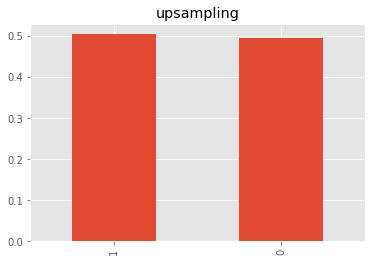

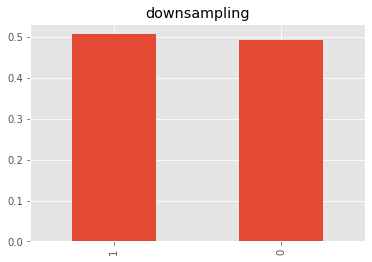

In [18]:
# формирование словаря целевого признака
target_dict = {'upsampling':target_up,'downsampling':target_down}
# графическая иллюстрация процентного соотношения классов целевого признака
for target_name, target_value in target_dict.items():
    target_value.value_counts(normalize=True).plot(kind='bar').set(title=target_name)
    plt.show()

### Промежуточные итоги
- Вектор целевого признака является несбалансированным. 90 процентов являются положительными комментариями. Отрицательные комментарии составляют 10 процентов выборки.
- Имеем четыре случая балансирования классов целевого признака:
    - (1) несбалансированность классов целевого признака;
    - (2) автоматическое балансирование на основе частоты классов целевого признака;
    - (3) увеличение наблюдений с меньшим классом целевого признака (увеличение доли отрицательных комментариев).;
    - (4) уменьшение наблюдений с преобладающим классом целевого признака (уменьшение доли положительных комментариев).
- Для случаев (3) и (4) положительные и отрицательные комментарии распределены поровну.

# 2. Обучение

Обучим два типа моделей: (а) логистическая регрессия, (б) наивная модель.

### Логистическая регрессия

In [19]:
# Определим фунцию, 
# которая обучает модель логистического регрессии с учетом способа балансирования классов целевого признака
def train_logreg(features_train, features_test, target_train, target_test, balanced='no'):
    '''
    Функция обучает модель логистической регрессии.
    features_train: корпус слов тренировочного множества
    features_test: корпус слов тестового множества
    target_train: целевой признак тренировочного множества
    target_test: целевой признак тестового множества
    balanced: четыре варианта балансирования: 
        (1) 'no' небалансированность классов целевого признака, 
        (2) 'yes' автоматическое балансирование классов целевого признака на основе частоты классов целевого признака,
        (3) 'up' балансирование через увеличение доли меньшего класса целевого признака [upsampling],
        (4) 'down' балансирование через выделение доли преобладающего класса целевого признака [downsampling].
    
    Результирующий параметр: метрика f1.
    ''' 
    # (1) несбалансированность классов целевого признака
    if balanced=='no':
        # запуск TFIDF на тренировочном множестве
        tfidf_no = TfidfVectorizer(stop_words=stopwords).fit(features_train)
        # преобразование тренировочного множества
        tfidf_train_no = tfidf_no.transform(features_train)
        # преобразование тестового множества
        tfidf_test_no = tfidf_no.transform(features_test)
        # обучение логистической регрессии на тренировочном множестве
        logreg = LogisticRegression(n_jobs=-1).fit(tfidf_train_no, target_train)
        # вычисление прогноза на тестовом множестве
        predictions = logreg.predict(tfidf_test_no)
        # вычисление метрики f1 на тестовом множестве
        return f1_score(target_test, predictions)
    # (2) сбалансированность классов целевого признака через частоту класса целевого признака:
    # n_samples / (n_classes * np.bincount(y). 
    # Источник: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    elif balanced=='yes':
        tfidf_yes = TfidfVectorizer(stop_words=stopwords).fit(features_train)
        tfidf_train_yes = tfidf_yes.transform(features_train)
        tfidf_test_yes = tfidf_yes.transform(features_test)
        # указываем balanced в аргументе class_weight
        logreg = LogisticRegression(n_jobs=-1, class_weight='balanced').fit(tfidf_train_yes, target_train)
        predictions = logreg.predict(tfidf_test_yes)
        return f1_score(target_test, predictions)
    # (3) увеличение доли меньшего класса целевого признака
    elif balanced=='up':
        # через функцию upsample преобразуем корпус слов и вектор целевого признака
        features_up, target_up = upsample(comments, 'text', 'toxic', 9)
        # выделим тренировочное и тестовое множества из увеличенного корпуса слов и вектора целевого признака
        features_train_up, features_test_up, target_train_up, target_test_up = train_test_split(features_up,
                                                                                                target_up,
                                                                                                test_size=0.2,
                                                                                                random_state=42)
        tfidf_up = TfidfVectorizer(stop_words=stopwords).fit(features_train_up)
        tfidf_train_up = tfidf_up.transform(features_train_up)
        tfidf_test_up = tfidf_up.transform(features_test_up)
        logreg = LogisticRegression(n_jobs=-1).fit(tfidf_train_up, target_train_up)
        predictions = logreg.predict(tfidf_test_up)
        return f1_score(target_test_up, predictions)
    # (4) выделение доли преобладающего класса целевого признака
    elif balanced=='down':
        # через функцию downsample преобразуем корпус слов и вектор целевого признака
        features_down, target_down = downsample(comments, 'text','toxic', 0.11)
        # выделим тренировочное и тестовое множества из уменьшенного корпуса слов и вектора целевого признака
        features_train_down, features_test_down, target_train_down, target_test_down = train_test_split(features_down,
                                                                                                        target_down, 
                                                                                                        test_size=0.2,
                                                                                                        random_state=42)
        tfidf_down = TfidfVectorizer(stop_words=stopwords).fit(features_train_down)
        tfidf_train_down = tfidf_down.transform(features_train_down)
        tfidf_test_down = tfidf_down.transform(features_test_down)
        logreg = LogisticRegression(n_jobs=-1).fit(tfidf_train_down, target_train_down)
        predictions = logreg.predict(tfidf_test_down)
        return f1_score(target_test_down, predictions)

In [20]:
# Через цикл for обучим модель логистической регрессии
# для четырех случаев сбалансированности классов целевого признака
try:
    for balance in ['no','yes','up','down']:
        print('----')
        print(balance)
        %time print(train_logreg(features_train, features_test, target_train, target_test, balanced=balance))
except:
    print('Возникла ошибка')
else:
    print('Логистическая регрессия успешно обучена')

----
no
0.7374697223774922
CPU times: user 13.6 s, sys: 232 ms, total: 13.8 s
Wall time: 20.8 s
----
yes
0.7530948170316963
CPU times: user 13.5 s, sys: 60 ms, total: 13.5 s
Wall time: 19.7 s
----
up
0.9613679974188728
CPU times: user 24.1 s, sys: 144 ms, total: 24.2 s
Wall time: 32.3 s
----
down
0.894510739856802
CPU times: user 2.53 s, sys: 12 ms, total: 2.54 s
Wall time: 3.83 s
Логистическая регрессия успешно обучена


### Наивная модель

In [21]:
# Определим функцию, которая обучает наивную модель на основе распределения классов целевого признака
def train_dummy(features_train, features_test, target_train, target_test):
    '''
    Функция обучает наивную модель.
    features_train: корпус слов тренировочного множества
    features_test: корпус слов тестового множества
    target_train: вектор целевого признака тренировочного множества
    target_test: вектор целевого признака тестового множества
    
    Результирующий параметр: метрика f1
    '''
    # запуск TFIDF на тренировочном множестве
    tfidf = TfidfVectorizer(stop_words=stopwords).fit(features_train)
    # преобразование тренировочного множества
    tfidf_train = tfidf.transform(features_train)
    # преобразование тестового множества
    tfidf_test = tfidf.transform(features_test)
    # инициализация наивной модели
    dum = DummyClassifier(strategy='stratified', random_state=42)
    # обучение наивной модели
    dum.fit(tfidf_train, target_train)
    # вычисление прогноза на тестовом множестве
    predictions = dum.predict(tfidf_test)
    return f1_score(target_test, predictions)

In [22]:
%%time
# Вычислим метрику f1 на основе обучения наивной модели
try:
    print(train_dummy(features_train, features_test, target_train, target_test))
except:
    print('Возникла ошибка')
else:
    print('Наивная модель успешно обучена')

0.10713183081197901
Наивная модель успешно обучена
CPU times: user 12.8 s, sys: 0 ns, total: 12.8 s
Wall time: 12.8 s


# 3. Выводы

- Обучена модель логистической регрессии. Метрика `f1_score` для четырех случаев балансирования целевого признака:
    - несбалансированность: `0.737`
    - балансирование на основе частоты классов целевого признака: `0.753`
    - увеличение доли отрицательных комментариев (меньший класс целевого признака): `0.961`
    - уменьшение доли положительных комментариев (преобладающий класс целевого признака): `0.894`
- Обучена наивная модель на основе распределения классов целевого признака. Метрика `f1_score` в случае несбалансированности классов целевого признака составляет `0.107`.
- Достигнута цель получения метрики `f1_score` не меньше `0.75` в трех случаях балансирования классов целевого признака: (а) через частоту классов, (б) увеличение доли меньшего класса, (в) уменьшение доли преобладающего класса.